--------------------------------------

# <center><b> Laptop Price Prediction </b></center>

--------------------------------------

## Problem Statement


### Download Datasets
This data project has been used as a take-home assignment in the recruitment process for the data science positions at Allegro.

### Assignment
Your task is to define and train a machine learning model for predicting the price of a laptop (buynow_price column in the dataset) based on its attributes. When testing and comparing your models, aim to minimize the RMSE measure.

### Data Description
The dataset has already been randomly divided into the training, validation and test sets. 

It is stored in 3 files: `train_dataset.json`, `val_dataset.json` and `test_dataset.json` respectively. Each file is JSON saved in orient=’columns’ format.

Example how to load the data:
```
import pandas as pd
dataset = pd.read_json("public-dataset.json")
dataset.columns

Index(['buynow_price', 'graphic card type', 'communications', 'resolution (px)', 'CPU cores', 'RAM size', 'operating system', 'drive type', 'input devices', 'multimedia', 'RAM type', 'CPU clock speed (GHz)', 'CPU model', 'state', 'drive memory size (GB)', 'warranty', 'screen size'], dtype='object')
```

### Practicalities
Prepare a model in Jupyter Notebook using Python. Only use the training data for training the model and check the model's performance on unseen data using the test dataset to make sure it does not overfit.

`Ensure that the notebook reflects your thought process. It’s better to show all the approaches, not only the final one (e.g. if you tested several models, you can show all of them). The path to obtaining the final model should be clearly shown.`



## Code for Analysis

### Imports and Functions

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

# View all columns in the dataset
pd.set_option('display.max_columns', None)

def check_null(df):
    Null_Count = pd.DataFrame(df.isnull().sum().sort_values(ascending=False), 
                              columns=['Null_Count'])    
    Null_Percentage = pd.DataFrame(round((df.isnull().sum()/len(df))*100, 2).sort_values(ascending=False),
                                   columns=['Null_Percentage'])    
    return pd.concat([Null_Count, Null_Percentage], axis = 1)

### Reading the Data

In [77]:
df = pd.read_json("train_dataset.json")
df.head(1)

# Making a copy of the original dataset
df1 = df.copy()

### Data Exploration

In [78]:
print("--------------------------------------------------")
print(df['resolution (px)'].value_counts())
print("--------------------------------------------------")
print(df['graphic card type'].value_counts())
print("--------------------------------------------------")
print(df['communications'].value_counts())
print("--------------------------------------------------")
print(df['drive type'].value_counts())
print("--------------------------------------------------")
print(df['input devices'].value_counts())
print("--------------------------------------------------")
print(df['multimedia'].value_counts())
print("--------------------------------------------------")
print(df['RAM type'].value_counts())
print("--------------------------------------------------")
print(df['CPU model'].value_counts())
print("--------------------------------------------------")
print(df['CPU clock speed (GHz)'].value_counts())
print("--------------------------------------------------")

--------------------------------------------------
resolution (px)
1920 x 1080    2765
1366 x 768     1234
1600 x 900      221
3840 x 2160      84
2560 x 1440      18
1920 x 1280      18
1280 x 800        7
3200 x 1800       6
2880 x 1620       3
2160 x 1440       2
1920 x 1200       2
other             1
Name: count, dtype: int64
--------------------------------------------------
graphic card type
dedicated graphics     2605
integrated graphics    1812
Name: count, dtype: int64
--------------------------------------------------
communications
[wi-fi, bluetooth, lan 10/100/1000 mbps]                                                                                              1128
[bluetooth, lan 10/100 mbps]                                                                                                           656
[bluetooth, lan 10/100/1000 mbps, lan 10/100 mbps, intel wireless display (widi), nfc (near field communication), modem 3g (wwan)]     429
[bluetooth, lan 10/100/1000 mbps]

### Preprocessing the data

In [79]:
def preprocessing_df(df):
    
    # Replace missing values with NaN explicitly
    df = df.fillna(np.nan)
    
    # Handle null values in RAM_size extraction
    df['RAM size'] = df['RAM size'].apply(lambda x: int(x.split(" ")[0]) if pd.notnull(x) else None)

    # Ensure proper integer conversion in CPU cores 
    df['CPU cores'] = df['CPU cores'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

    def has_feature(feature_name):
        def extract_feature(x):
            if x is None:  # Explicitly check for None 
                return 0
            elif isinstance(x, str):  
                return 1 if feature_name.lower() in x.lower() else 0
            elif isinstance(x, list):  
                return 1 if any(feature_name.lower() in item.lower() for item in x) else 0 
            else:
                try:
                    text = str(x)
                    return 1 if feature_name.lower() in text.lower() else 0
                except:
                    return 0 
        return extract_feature

    df['operating system'] = df['operating system']

    df['state'] = df['state'].apply(lambda x: 1 if x == 'new' else 0)

    # Create one-hot encoded features
    df['has_touchpad'] = df['input devices'].apply(has_feature('touchpad'))
    df['has_keyboard'] = df['input devices'].apply(has_feature('keyboard'))
    df['has_numeric_keyboard'] = df['input devices'].apply(has_feature('numeric keyboard'))
    df['has_illuminated_keyboard'] = df['input devices'].apply(has_feature('illuminated keyboard'))
    df.drop('input devices', axis=1, inplace=True)

    # Create multimedia features
    df['has_speakers'] = df['multimedia'].apply(has_feature('speaker'))
    df['has_SD_card_reader'] = df['multimedia'].apply(has_feature('SD card'))
    df['has_microphone'] = df['multimedia'].apply(has_feature('microphone'))
    df['has_camera'] = df['multimedia'].apply(has_feature('camera'))
    

    # Create communications features
    df['has_modem_4g'] = df['communications'].apply(has_feature('modem 4g'))
    df['has__bluetooth'] = df['communications'].apply(has_feature('bluetooth'))
    df['has_lan'] = df['communications'].apply(has_feature('lan'))
    df['has_modem_3g'] = df['communications'].apply(has_feature('modem 3g'))
    df['has_wifi'] = df['communications'].apply(has_feature('wifi'))
    df['has_widi'] = df['communications'].apply(has_feature('widi'))
    

    # Create features for Operating System
    df['has_win10_home'] = df['operating system'].apply(has_feature('windows 10 home'))
    df['has_win10_professional'] = df['operating system'].apply(has_feature('windows 10 professional'))
    df['has_win7_professional'] = df['operating system'].apply(has_feature('windows 7 professional'))
    df['has_win8_1_home'] = df['operating system'].apply(has_feature('windows 8.1 home'))
    df['has_win8_1_professional'] = df['operating system'].apply(has_feature('windows 8.1 professional'))
    df['has_linux'] = df['operating system'].apply(has_feature('linux'))
    

    # Converting Graphic Card Type to numeric
    df['graphic card type'] = df['graphic card type'].apply(lambda x: 1 if x == 'dedicated graphics' else 0)

    # Dropping the non-required columns
    df.drop('multimedia', axis=1, inplace=True)
    df.drop('communications', axis=1, inplace=True)
    df.drop('operating system', axis=1, inplace=True)
    df.drop('state', axis=1, inplace=True)

    return df


def null_value_handling(df):

    # First we drop rows with more than 5 null values
    df = df.dropna(axis=0, thresh=5)

    num_var = ['CPU clock speed (GHz)', 'CPU cores', 'RAM size', 'drive memory size (GB)']
    cat_var = ['RAM type', 'resolution (px)', 'CPU model', 'graphic card type','drive type', 'screen size']

    for var in num_var:
        # Filling the numerical variable (num_var) with median values
        df[var] = df[var].fillna(df[var].median())
    
    for var in cat_var:        
        # Filling the categorical variable (cat_var) with most frequent values
        df[var] = df[var].fillna(df[var].mode()[0])
    
    return df

def one_hot_encode(df, columns):
    """
    Performs one-hot encoding on specified columns in a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the columns to encode.
        columns (list): A list of column names to be one-hot encoded.

    Returns:        pd.DataFrame: The DataFrame with the one-hot encoded columns.
    """
    encoder = OneHotEncoder(sparse_output=False)  
    encoded_data = encoder.fit_transform(df[columns])
    encoded_columns = encoder.get_feature_names_out(columns)
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns)

    return pd.concat([df.drop(columns, axis=1), encoded_df], axis=1)

def ordinal_encode(df, columns):
    """
    Performs ordinal encoding on specified columns in a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the columns to encode.
        columns (list): A list of column names to be ordinal encoded.

    Returns:        pd.DataFrame: The DataFrame with the encoded columns.
    """
    encoder = OrdinalEncoder()
    df[columns] = encoder.fit_transform(df[columns])
    return df



In [80]:
# Preprocessing the data
df = preprocessing_df(df)
df = null_value_handling(df)

# Ordinal Encoding
ordinal_encode_columns = ['resolution (px)', 'drive type', 'RAM type', 'screen size', 'CPU model', 'warranty']
df = ordinal_encode(df, ordinal_encode_columns)

df.head()


,graphic card type,resolution (px),CPU cores,RAM size,drive type,RAM type,CPU clock speed (GHz),CPU model,drive memory size (GB),warranty,screen size,buynow_price,has_touchpad,has_keyboard,has_numeric_keyboard,has_illuminated_keyboard,has_speakers,has_SD_card_reader,has_microphone,has_camera,has_modem_4g,has__bluetooth,has_lan,has_modem_3g,has_wifi,has_widi,has_win10_home,has_win10_professional,has_win7_professional,has_win8_1_home,has_win8_1_professional,has_linux
7233,1,3.0,4,32.0,4.0,2.0,2.6,12.0,1250.0,1.0,5.0,4999.0,1,1,1,1,1,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0
5845,1,1.0,4,8.0,3.0,0.0,2.4,12.0,256.0,2.0,4.0,2649.0,1,1,1,0,1,1,1,1,0,1,1,0,0,0,1,0,0,0,0,0
10303,0,3.0,2,8.0,1.0,2.0,1.6,12.0,1000.0,1.0,4.0,3399.0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
10423,0,3.0,2,8.0,3.0,2.0,2.5,11.0,500.0,1.0,4.0,1599.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5897,0,7.0,4,8.0,3.0,2.0,1.2,17.0,256.0,1.0,1.0,4499.0,1,1,0,1,1,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0


### Visualizing the Original data

In [81]:
df1.head(1)

,graphic card type,communications,resolution (px),CPU cores,RAM size,operating system,drive type,input devices,multimedia,RAM type,CPU clock speed (GHz),CPU model,state,drive memory size (GB),warranty,screen size,buynow_price
7233,dedicated graphics,"[bluetooth, lan 10/100/1000 mbps]",1920 x 1080,4,32 gb,[no system],ssd + hdd,"[keyboard, touchpad, illuminated keyboard, num...","[SD card reader, camera, speakers, microphone]",ddr4,2.6,intel core i7,new,1250.0,producer warranty,"17"" - 17.9""",4999.0


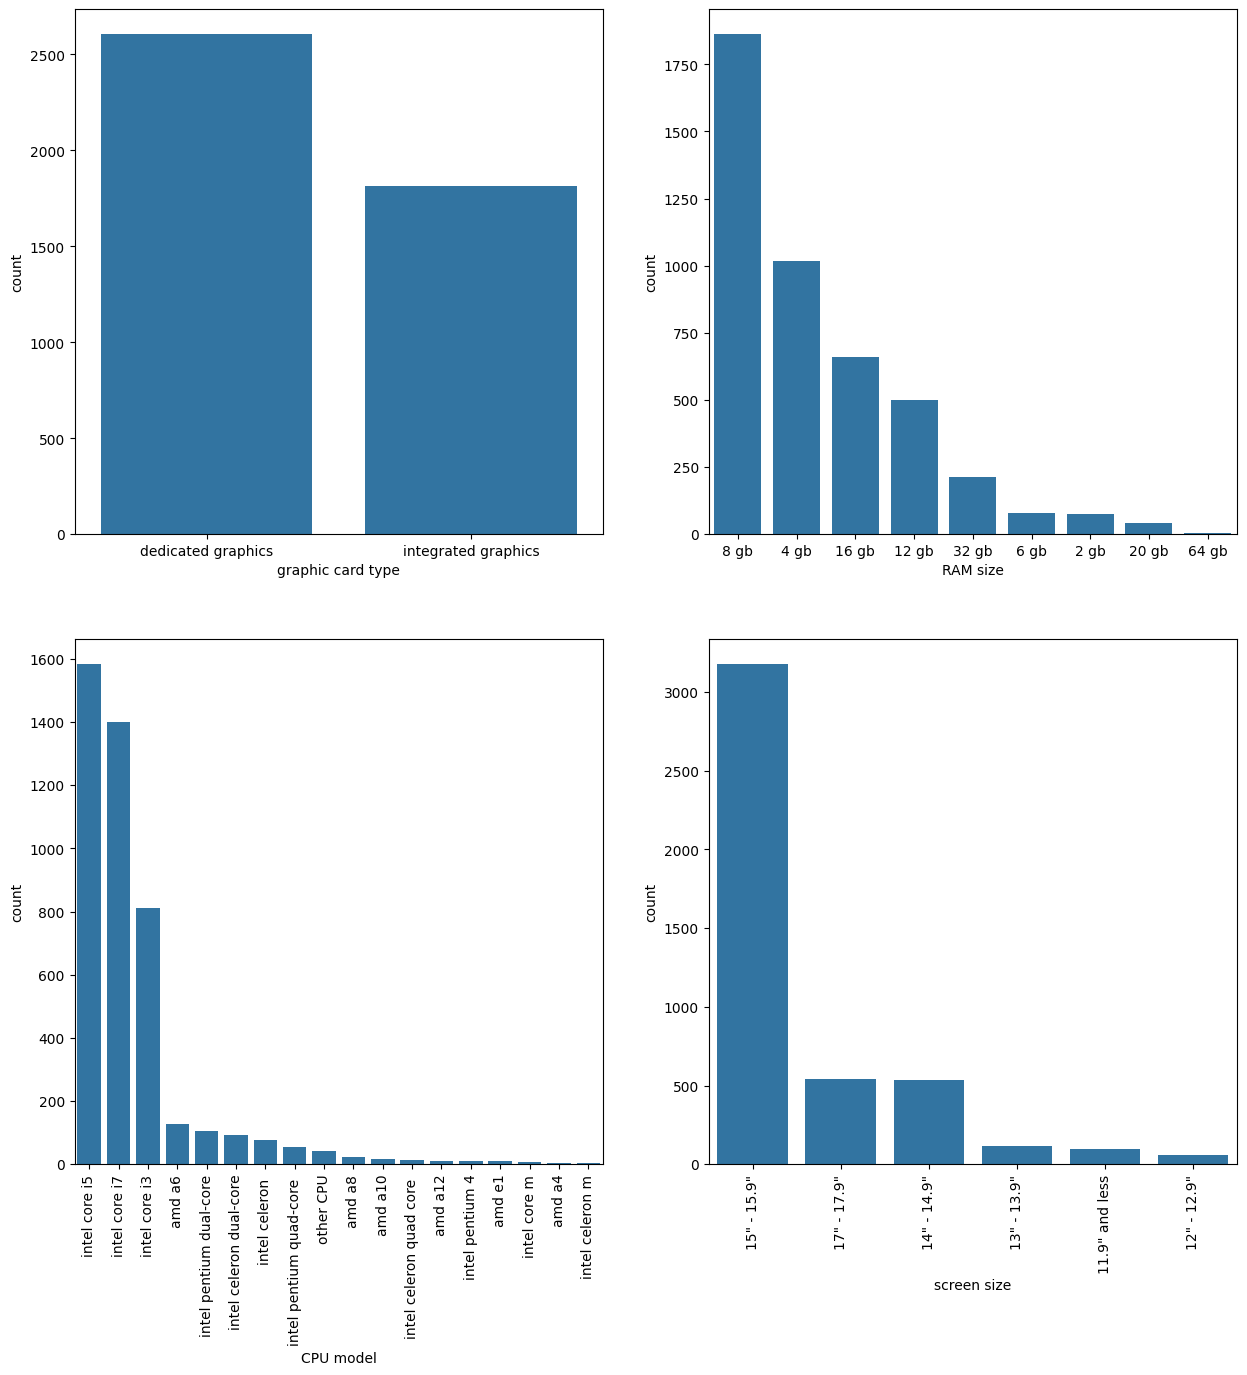

In [82]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
sns.countplot(x='graphic card type', data=df1, order = df1['graphic card type'].value_counts().index)

plt.subplot(2, 2, 2)
sns.countplot(x='RAM size', data=df1, order = df1['RAM size'].value_counts().index)

plt.subplot(2, 2, 3)
sns.countplot(x='CPU model', data=df1, order = df1['CPU model'].value_counts().index)
plt.xticks(rotation=90)

plt.subplot(2, 2, 4)
sns.countplot(x='screen size', data=df1, order = df1['screen size'].value_counts().index)
plt.xticks(rotation=90)

plt.show()

<Axes: xlabel='warranty', ylabel='count'>

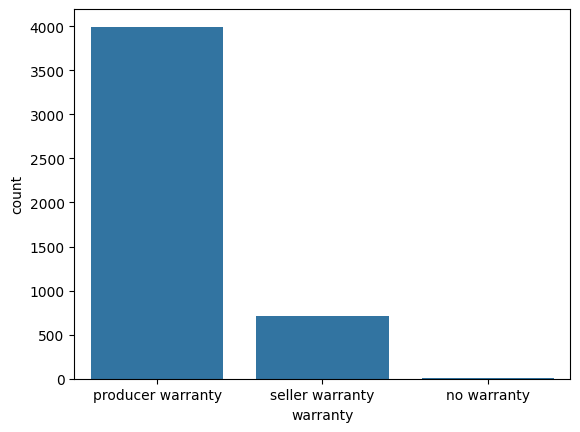

In [83]:
sns.countplot(x='warranty', data=df1, order = df1['warranty'].value_counts().index)

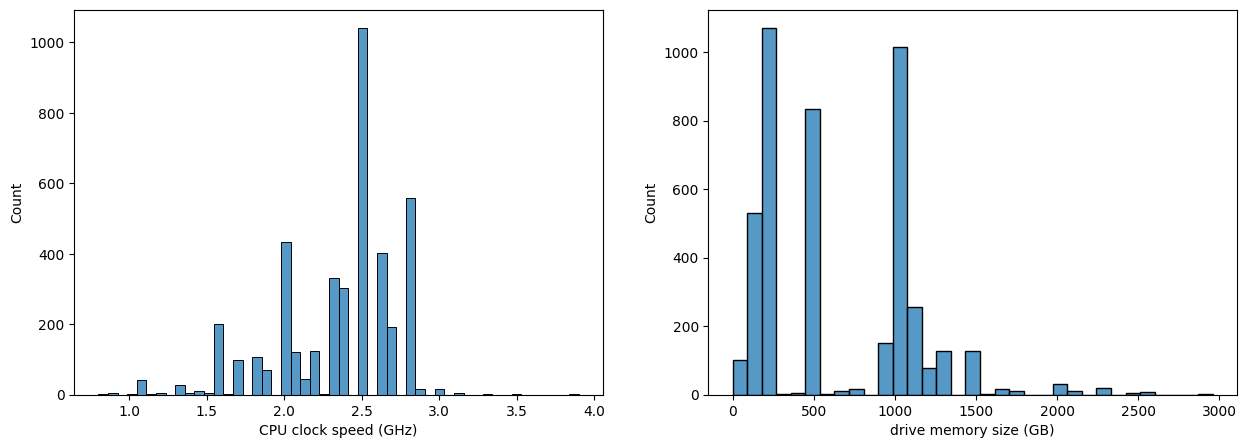

In [84]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.histplot(x='CPU clock speed (GHz)', data=df1)

plt.subplot(1,2,2)
sns.histplot(x='drive memory size (GB)', data=df1)

plt.show()

In [85]:
df1.head(1)

,graphic card type,communications,resolution (px),CPU cores,RAM size,operating system,drive type,input devices,multimedia,RAM type,CPU clock speed (GHz),CPU model,state,drive memory size (GB),warranty,screen size,buynow_price
7233,dedicated graphics,"[bluetooth, lan 10/100/1000 mbps]",1920 x 1080,4,32 gb,[no system],ssd + hdd,"[keyboard, touchpad, illuminated keyboard, num...","[SD card reader, camera, speakers, microphone]",ddr4,2.6,intel core i7,new,1250.0,producer warranty,"17"" - 17.9""",4999.0


### Handling Collinearity

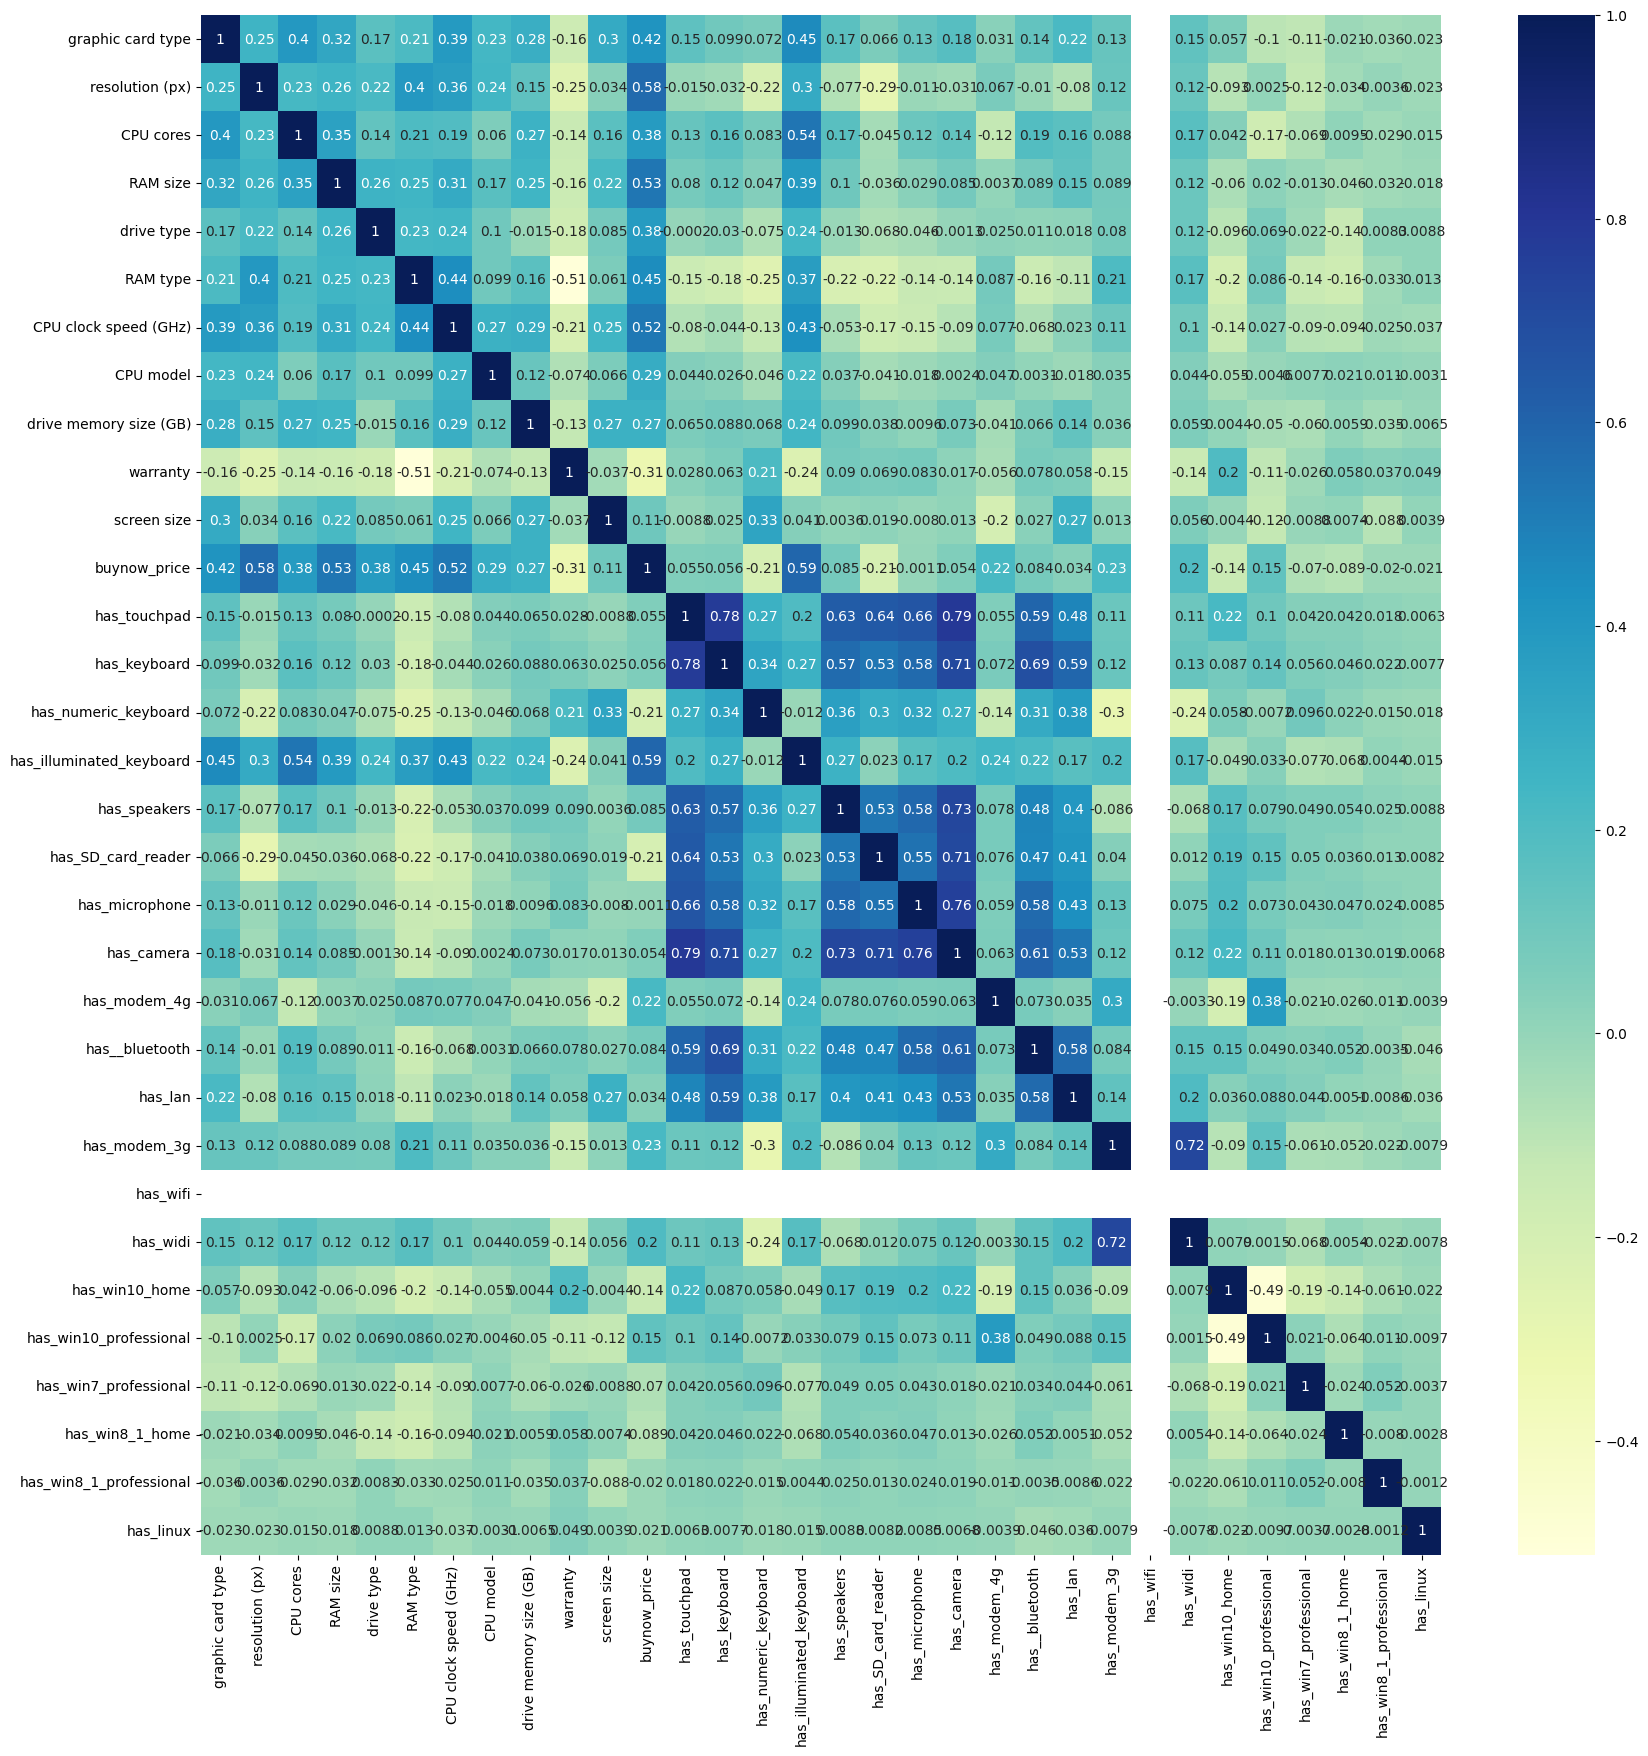

In [86]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(method='pearson'), annot=True, cmap='YlGnBu')
plt.show()

## Modelling

### Reading & Processing the Validation Data

In [87]:
### Reading & Processing the Validation Data
# ------------------------------------------
df_val = pd.read_json('val_dataset.json')
# Processing the data and also null value handling

df_val = preprocessing_df(df_val)
df_val = null_value_handling(df_val)

# Ordinal Encoding
ordinal_encode_columns = ['resolution (px)', 'drive type', 'RAM type', 'screen size', 'CPU model', 'warranty']
df_val = ordinal_encode(df_val, ordinal_encode_columns)

df_val.head(1)

,graphic card type,resolution (px),CPU cores,RAM size,drive type,RAM type,CPU clock speed (GHz),CPU model,drive memory size (GB),warranty,screen size,buynow_price,has_touchpad,has_keyboard,has_numeric_keyboard,has_illuminated_keyboard,has_speakers,has_SD_card_reader,has_microphone,has_camera,has_modem_4g,has__bluetooth,has_lan,has_modem_3g,has_wifi,has_widi,has_win10_home,has_win10_professional,has_win7_professional,has_win8_1_home,has_win8_1_professional,has_linux
3849,1,3.0,4,8.0,4.0,2.0,2.5,11.0,1128.0,1.0,4.0,3829.0,1,1,0,1,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0


### Modelling - Model 1: Linear Regression

#### Handling Collinearity between variables


In [88]:
def compute_vif(df, features):
    """
    Calculates the Variance Inflation Factor (VIF) for each feature.

    Args:
        df (pd.DataFrame): DataFrame containing the features.
        features (list): List of feature names.

    Returns:
        pd.DataFrame: DataFrame with 'feature' and 'VIF' columns, sorted by VIF.
    """

    X = df[features]  
    vif_values = pd.Series([variance_inflation_factor(X.values, i) 
                            for i in range(X.shape[1])], 
                           index=X.columns)

    vif_data = pd.DataFrame({'feature': X.columns, 'VIF': vif_values})
    return vif_data.sort_values(by=['VIF'], ascending=False).reset_index(drop=True)

def covariance_handling(df):
    covar_flag = True
    counter = 0

    while covar_flag:
        features = df.columns.tolist()
        vif_df = compute_vif(df, features)
        
        if vif_df.iloc[0]['VIF'] > 5:
            drop_feature = vif_df.iloc[0]['feature']
            df.drop(drop_feature, axis=1, inplace=True)
            counter+=1
        else:
            covar_flag = False

    print(f"Columns Removed using VIF: {counter}")
    return df
old_df = df.copy()
new_df = covariance_handling(df)

Columns Removed using VIF: 16


In [89]:
old_df.shape, new_df.shape

((4711, 32), (4711, 16))

In [ ]:
def linear_regression_model(train_df, val_df):
    X_train = train_df.drop('buynow_price', axis=1)
    y_train = train_df['buynow_price']

    x_val = val_df.drop('buynow_price', axis=1)
    y_val = val_df['buynow_price']

    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    y_pred = lr_model.predict(x_val)

    # Printing the RMSE Error
    print(f"RMSE Error: {sklearn.metrics.mean_squared_error(y_val, y_pred, squared=False)}")
    print(f"R^2 Score: {sklearn.metrics.r2_score(y_val, y_pred)}")
    print("\n")
    # Plotting the results
    sns.regplot(x=y_pred, y=y_val)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.show()



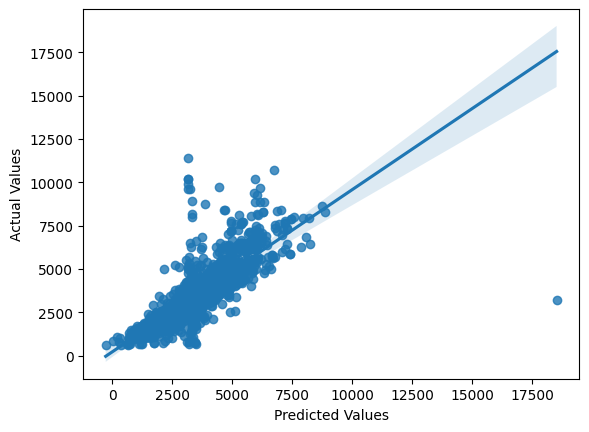

In [18]:


print(rmse)

1026.7627873852123


c:\Users\nitan\miniconda3\envs\analysis1\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Model 2: Random Forest Regressor

In [19]:
from sklearn.ensemble import RandomForestRegressor

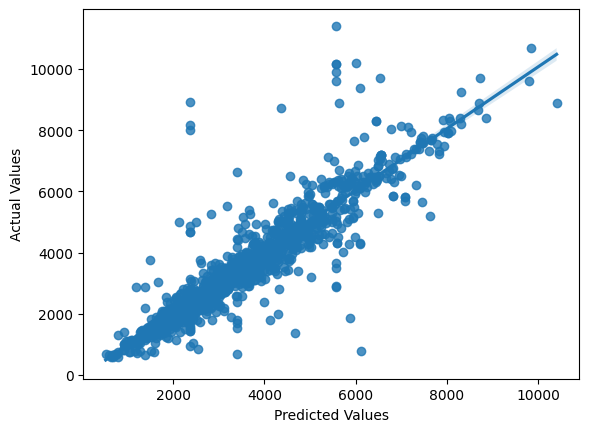

In [20]:
rf_1 = RandomForestRegressor()

rf_1.fit(X_train, y_train)

y_pred = rf_1.predict(x_val)


sns.regplot(x=y_pred, y=y_val)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

In [21]:
rmse = sklearn.metrics.mean_squared_error(y_val, y_pred, squared=False)

print(rmse)

682.762390645349


c:\Users\nitan\miniconda3\envs\analysis1\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
